In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
from arch.unitroot import PhillipsPerron
from typing import List

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('15/2/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('30/11/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

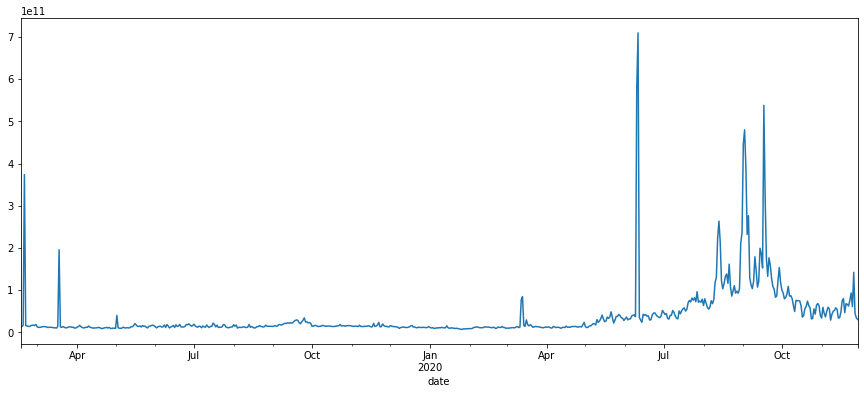

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice1['gasValue'] = np.log(gas_slice1['gasValue'] / gas_slice1['gasValue'].shift(1))
gas_slice1.dropna(inplace=True)

In [10]:
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_slice2['gasValue'] = np.log(gas_slice2['gasValue'] / gas_slice2['gasValue'].shift(1))
gas_slice2.dropna(inplace=True)

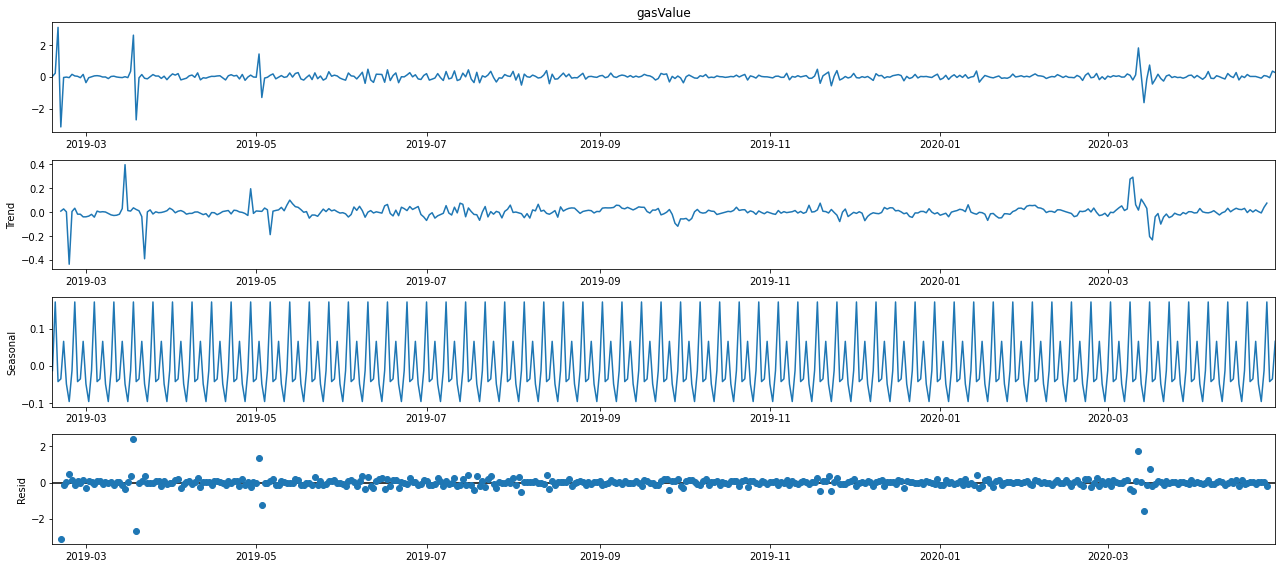

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition1.plot()
plt.show()

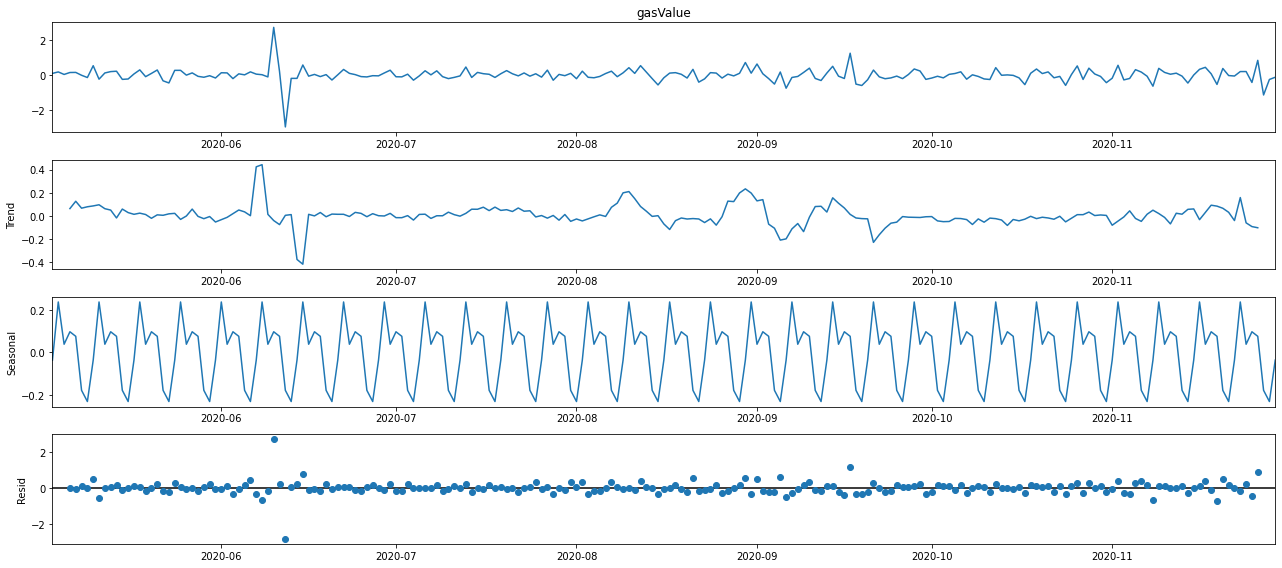

In [12]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition2.plot()
plt.show()

In [13]:
gas_slice1['gasValue'] = gas_slice1['gasValue'] - decomposition1.seasonal

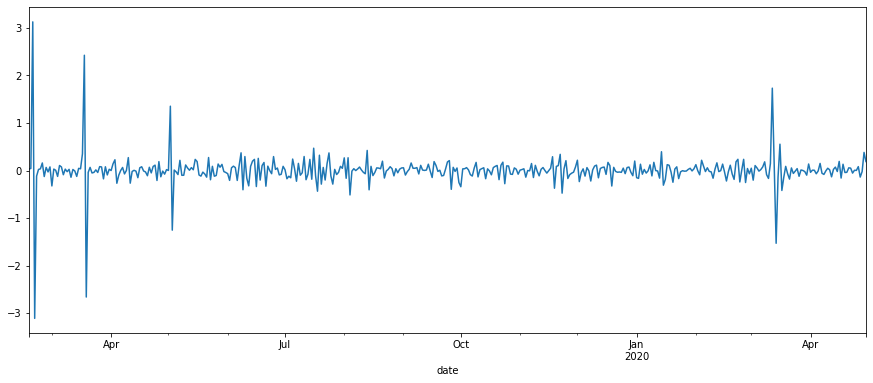

In [14]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [15]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - decomposition2.seasonal

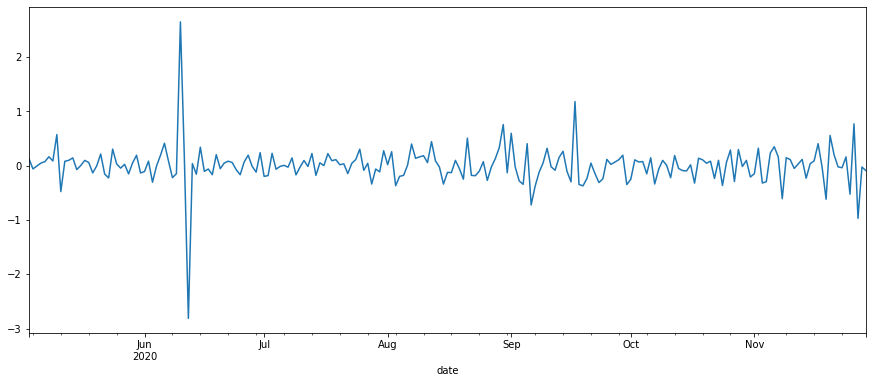

In [16]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [17]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.182009e+01
P-Value                 8.454788e-22
# Lags Used             6.000000e+00
# Observations Used     4.320000e+02
Critical Value (1%)    -3.445578e+00
Critical Value (5%)    -2.868254e+00
Critical Value (10%)   -2.570346e+00
dtype: float64


In [18]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.222292e+00
P-Value                 2.096094e-10
# Lags Used             9.000000e+00
# Observations Used     2.010000e+02
Critical Value (1%)    -3.463309e+00
Critical Value (5%)    -2.876029e+00
Critical Value (10%)   -2.574493e+00
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [19]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.16562055918555332
p-value: 0.1
num lags: 110
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [20]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.3048552805078578
p-value: 0.1
num lags: 33
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

Let's test both series with augmented Phillips–Perron test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [21]:
pp = PhillipsPerron(gas_slice1['gasValue'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -58.626
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [22]:
pp = PhillipsPerron(gas_slice2['gasValue'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -22.713
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# DAOhaus activity series

Let's check what about the activity series.

In [23]:
daohaus: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daohaus_activity.csv'), header=0)
daohaus = transform_date_series(df=daohaus, date_key='date')

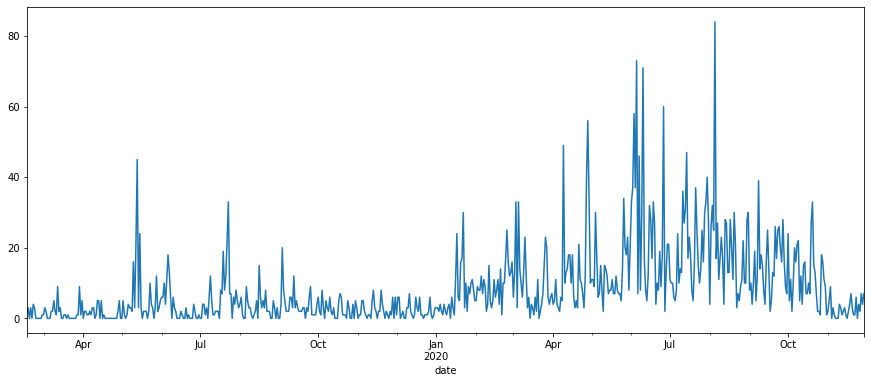

In [24]:
daohaus_plot = filter_series(df=daohaus, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daohaus_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [25]:
daohaus_slice1 = filter_series(df=daohaus, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
daohaus_slice1.drop(daohaus_slice1.index[0], inplace=True)

In [26]:
daohaus_slice2 = filter_series(df=daohaus, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daohaus_slice2.drop(daohaus_slice2.index[0], inplace=True)

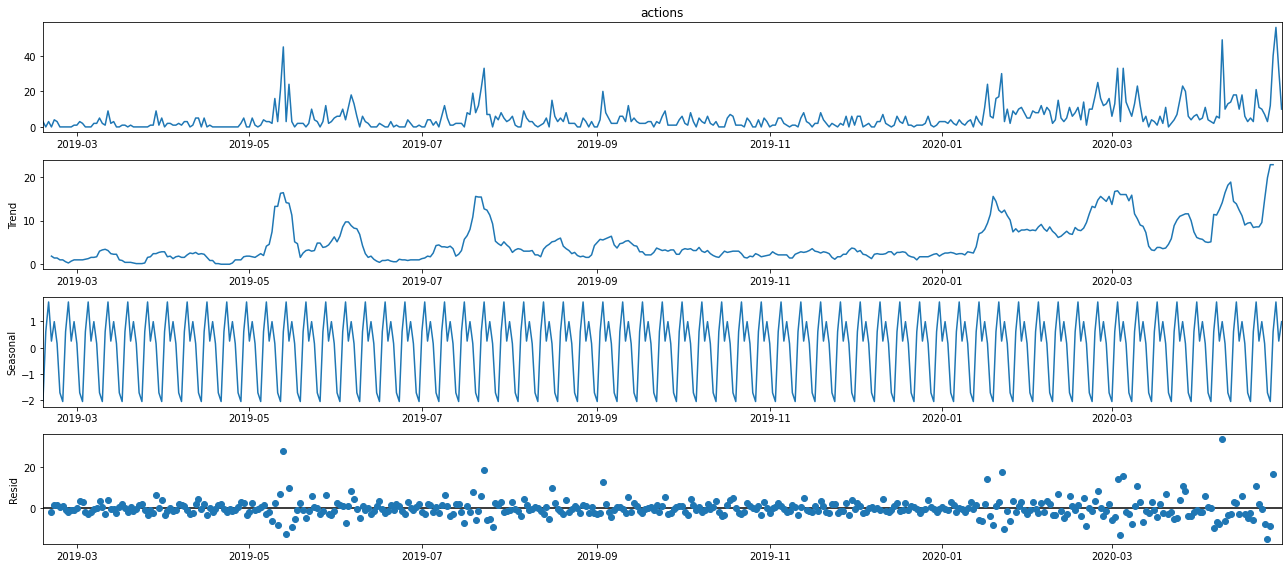

In [27]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=daohaus_slice1['actions'], model='additive')
fig = decomposition1.plot()
plt.show()

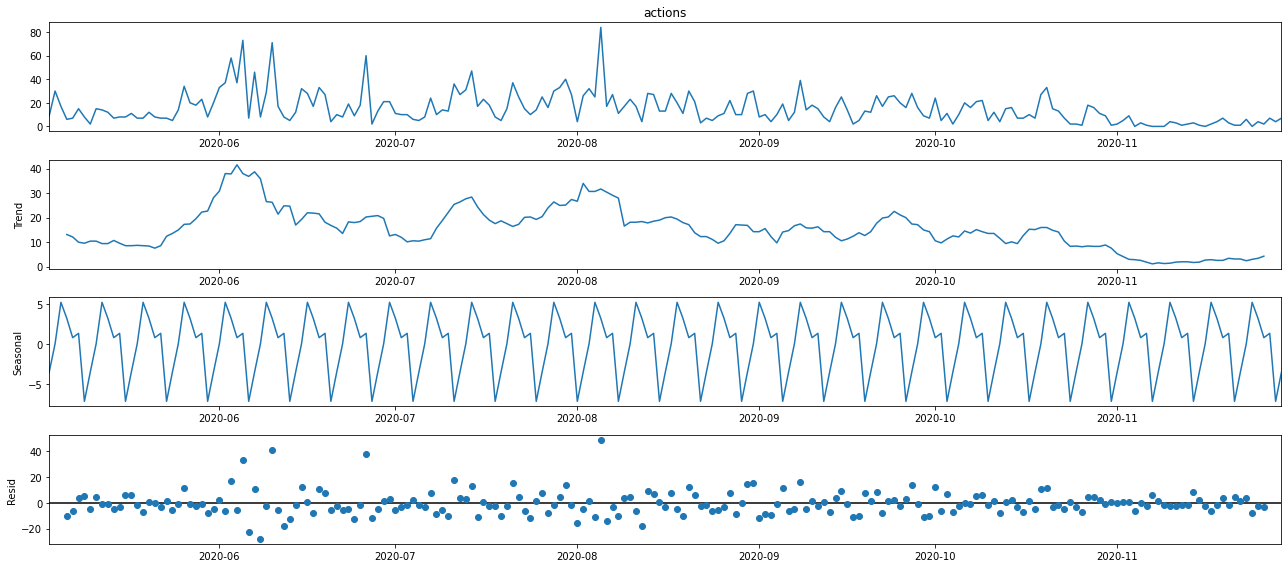

In [28]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=daohaus_slice2['actions'], model='additive')
fig = decomposition2.plot()
plt.show()

In [29]:
daohaus_slice1['actions'] = daohaus_slice1['actions'] - decomposition1.seasonal

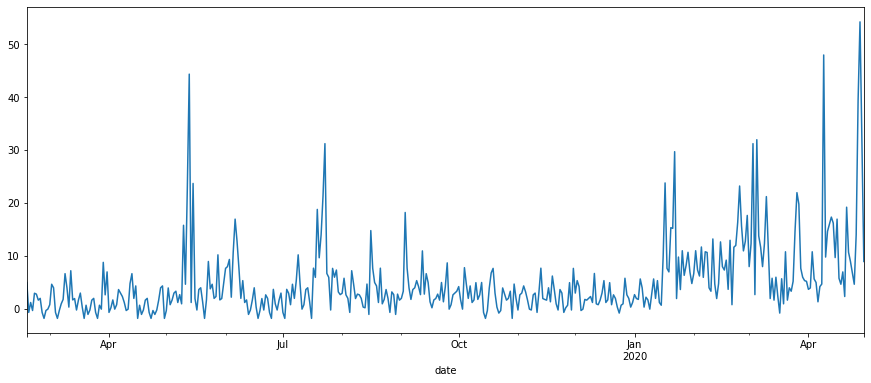

In [30]:
daohaus_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [31]:
daohaus_slice2['actions'] = daohaus_slice2['actions'] - decomposition2.seasonal

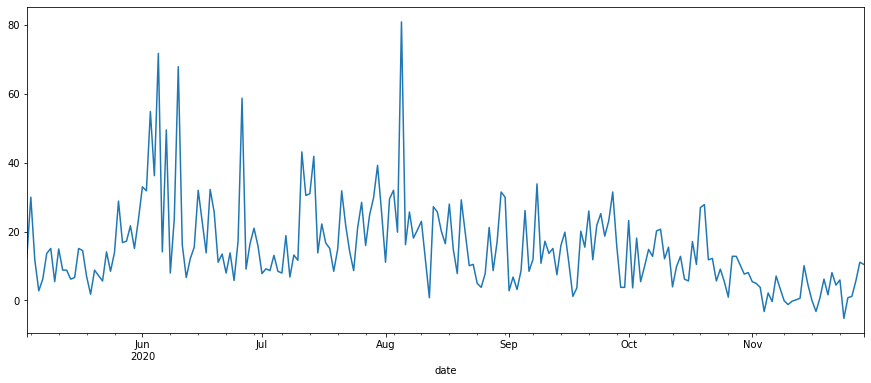

In [32]:
daohaus_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [33]:
print_adf(df=daohaus_slice1, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.484068
P-Value                   0.000210
# Lags Used               4.000000
# Observations Used     434.000000
Critical Value (1%)      -3.445508
Critical Value (5%)      -2.868223
Critical Value (10%)     -2.570330
dtype: float64


In [34]:
print_adf(df=daohaus_slice2, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.666552
P-Value                   0.000097
# Lags Used               2.000000
# Observations Used     208.000000
Critical Value (1%)      -3.462186
Critical Value (5%)      -2.875538
Critical Value (10%)     -2.574231
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [35]:
print_kpss(df=daohaus_slice1, key='actions')

KPSS Statistic: 1.4487418963468686
p-value: 0.01
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [36]:
print_kpss(df=daohaus_slice2, key='actions')

KPSS Statistic: 0.8826244551678237
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

Let's test both series with augmented Phillips–Perron test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [37]:
pp = PhillipsPerron(daohaus_slice1['actions'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -14.874
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [38]:
pp = PhillipsPerron(daohaus_slice2['actions'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -12.485
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [39]:
slice1: pd.DataFrame = pd.DataFrame(
    {'actions': daohaus_slice1['actions'].tolist(),
     'gasValue': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1222  , p=0.1459  , df_denom=435, df_num=1
ssr based chi2 test:   chi2=2.1368  , p=0.1438  , df=1
likelihood ratio test: chi2=2.1316  , p=0.1443  , df=1
parameter F test:         F=2.1222  , p=0.1459  , df_denom=435, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5106  , p=0.2219  , df_denom=432, df_num=2
ssr based chi2 test:   chi2=3.0561  , p=0.2170  , df=2
likelihood ratio test: chi2=3.0455  , p=0.2181  , df=2
parameter F test:         F=1.5106  , p=0.2219  , df_denom=432, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3392  , p=0.2611  , df_denom=429, df_num=3
ssr based chi2 test:   chi2=4.0833  , p=0.2526  , df=3
likelihood ratio test: chi2=4.0643  , p=0.2546  , df=3
parameter F test:         F=1.3392  , p=0.2611  , df_denom=429, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0341  , p=0.3892  

In [40]:
slice2: pd.DataFrame = pd.DataFrame(
    {'actions': daohaus_slice2['actions'].tolist(),
     'gasValue': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8249  , p=0.3648  , df_denom=207, df_num=1
ssr based chi2 test:   chi2=0.8369  , p=0.3603  , df=1
likelihood ratio test: chi2=0.8352  , p=0.3608  , df=1
parameter F test:         F=0.8249  , p=0.3648  , df_denom=207, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0470  , p=0.0497  , df_denom=204, df_num=2
ssr based chi2 test:   chi2=6.2434  , p=0.0441  , df=2
likelihood ratio test: chi2=6.1519  , p=0.0461  , df=2
parameter F test:         F=3.0470  , p=0.0497  , df_denom=204, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7142  , p=0.0460  , df_denom=201, df_num=3
ssr based chi2 test:   chi2=8.4262  , p=0.0380  , df=3
likelihood ratio test: chi2=8.2600  , p=0.0409  , df=3
parameter F test:         F=2.7142  , p=0.0460  , df_denom=201, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3485  , p=0.0557  

# VAR analysis

## Slice 1

In [41]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)

In [42]:
slice1['actions'] = daohaus_slice1['actions'].tolist()

In [43]:
model1 = VAR(slice1)
model1.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,1.258,1.277,3.520,1.266
1,0.8842,0.9410,2.421,0.9066
2,0.7176,0.8123*,2.049,0.7550
3,0.6911,0.8236,1.996,0.7434*
4,0.6878,0.8582,1.989,0.7551
5,0.6704*,0.8787,1.955*,0.7527
6,0.6796,0.9258,1.973,0.7768
7,0.6868,0.9708,1.987,0.7989
8,0.6995,1.021,2.013,0.8266
9,0.7126,1.072,2.039,0.8546


In [44]:
results1 = model1.fit(maxlags=2, ic='bic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Jan, 2021
Time:                     13:14:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.22991
Nobs:                     437.000    HQIC:                   1.17339
Log likelihood:          -1478.49    FPE:                    3.11599
AIC:                      1.13654    Det(Omega_mle):         3.04589
--------------------------------------------------------------------
Results for equation gasValue
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.027162         0.018588           -1.461           0.144
L1.gasValue        -0.506277         0.045295          -11.177           0.000
L1.actions         -0.000651         0.002372           -0.274   

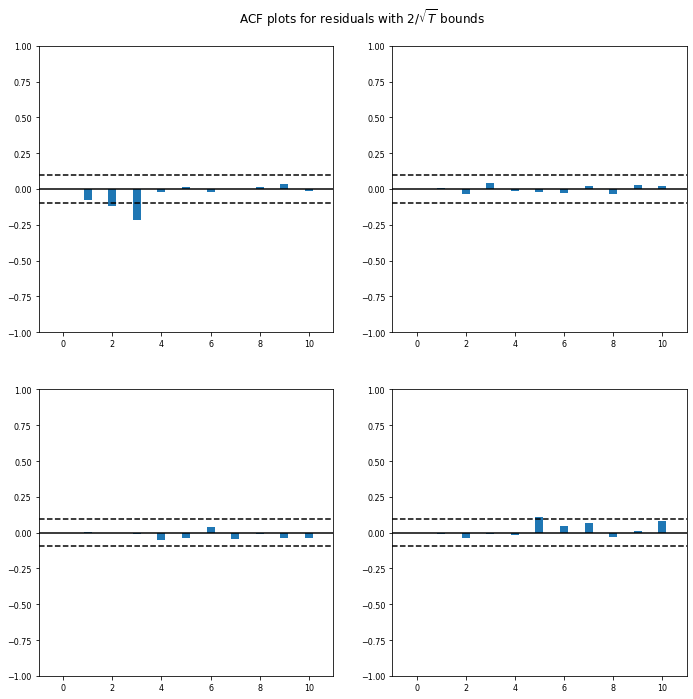

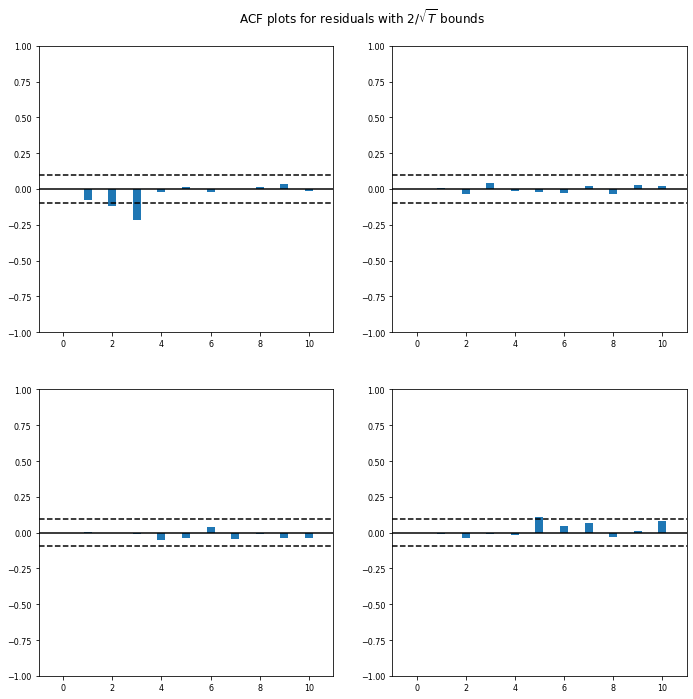

In [45]:
results1.plot_acorr()

### Impulse Response

In [46]:
irf1 = results1.irf(20)

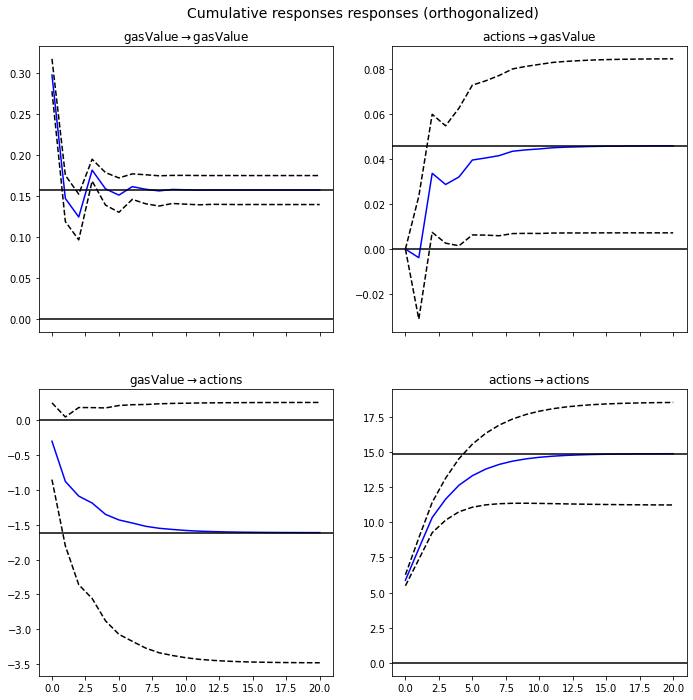

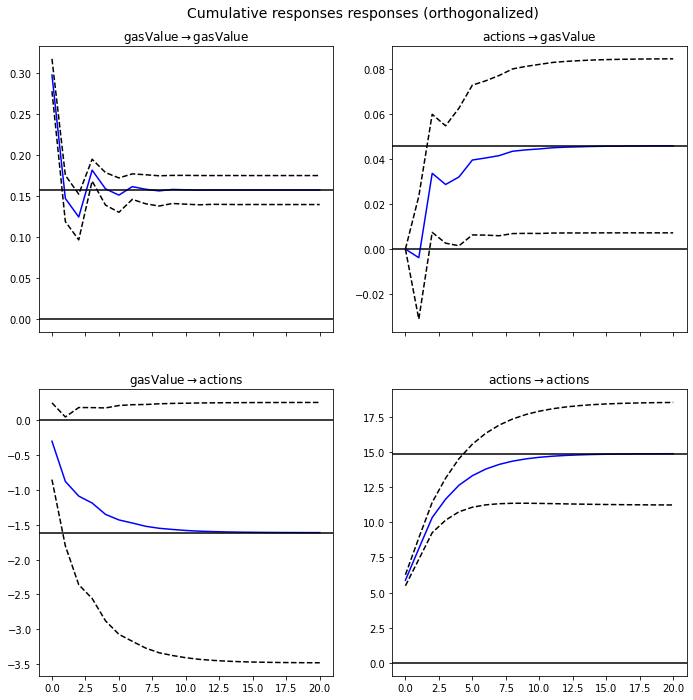

In [47]:
irf1.plot_cum_effects(orth=True)

In [48]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.999868  0.000132
2     0.987394  0.012606
3     0.987538  0.012462
4     0.987499  0.012501
5     0.987026  0.012974
6     0.987031  0.012969
7     0.987023  0.012977
8     0.986991  0.013009
9     0.986989  0.013011
10    0.986987  0.013013
11    0.986985  0.013015
12    0.986984  0.013016
13    0.986984  0.013016
14    0.986984  0.013016
15    0.986984  0.013016
16    0.986984  0.013016
17    0.986984  0.013016
18    0.986984  0.013016
19    0.986984  0.013016

FEVD for actions
      gasValue   actions
0     0.002600  0.997400
1     0.010585  0.989415
2     0.010413  0.989587
3     0.010241  0.989759
4     0.010582  0.989418
5     0.010612  0.989388
6     0.010602  0.989398
7     0.010624  0.989376
8     0.010628  0.989372
9     0.010629  0.989371
10    0.010630  0.989370
11    0.010631  0.989369
12    0.010631  0.989369
13    0.010631  0.989369
14    0.010631  0.989369
15    0.010631  0.989369
16    0.010631

In [49]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
4.801e+04,9.488,0.000,4


In [50]:
results1.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
81.23,92.81,0.214,72


In [51]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.133,3.841,0.287,1


In [52]:
results1.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.511,3.006,0.221,"(2, 864)"


## Slice 2

In [53]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['actions'] = daohaus_slice2['actions'].tolist()

In [64]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,3.119,3.152,22.62,3.132
1,2.994,3.093,19.96,3.034
2,2.806,2.970*,16.55,2.873
3,2.776*,3.007,16.06*,2.870*
4,2.808,3.104,16.58,2.928
5,2.811,3.173,16.63,2.957
6,2.842,3.269,17.15,3.015
7,2.852,3.345,17.33,3.052
8,2.869,3.428,17.64,3.095
9,2.891,3.515,18.03,3.143


In [65]:
results2 = model2.fit(maxlags=2, ic='bic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Jan, 2021
Time:                     13:15:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.92912
Nobs:                     209.000    HQIC:                   2.83385
Log likelihood:          -872.497    FPE:                    15.9461
AIC:                      2.76920    Det(Omega_mle):         15.2097
--------------------------------------------------------------------
Results for equation gasValue
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.010498         0.042656           -0.246           0.806
L1.gasValue        -0.157757         0.066344           -2.378           0.017
L1.actions          0.004539         0.002021            2.246   

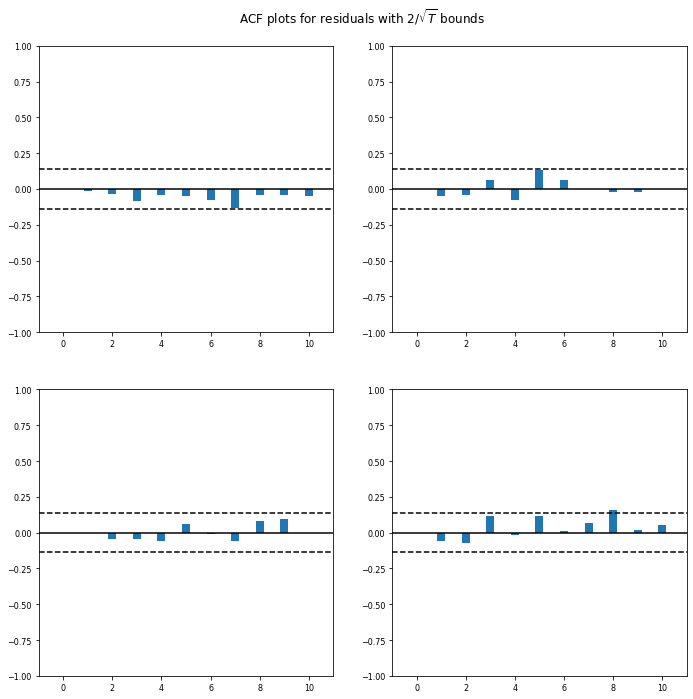

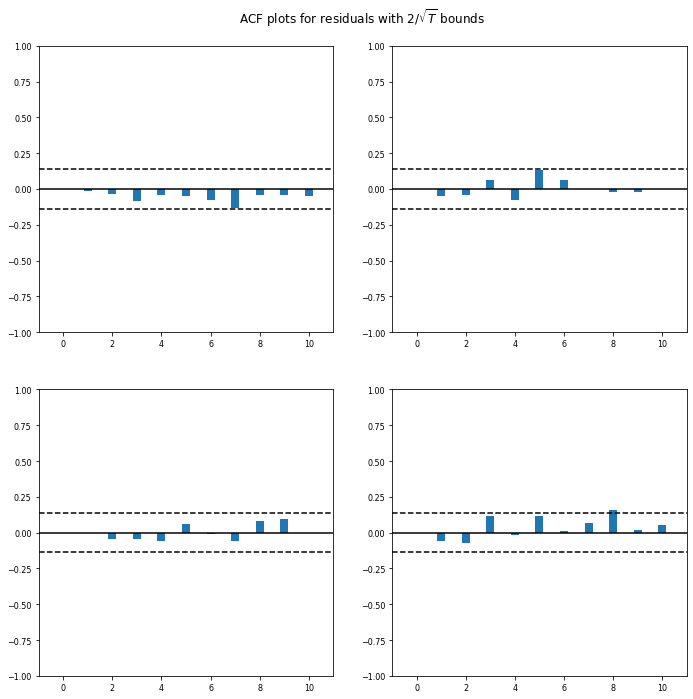

In [66]:
results2.plot_acorr()

### Impulse Response

In [67]:
irf2 = results2.irf(20)

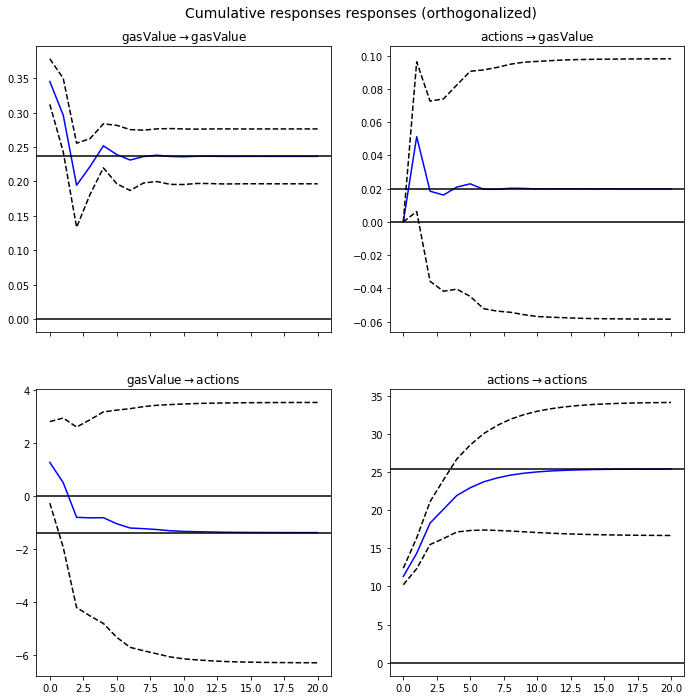

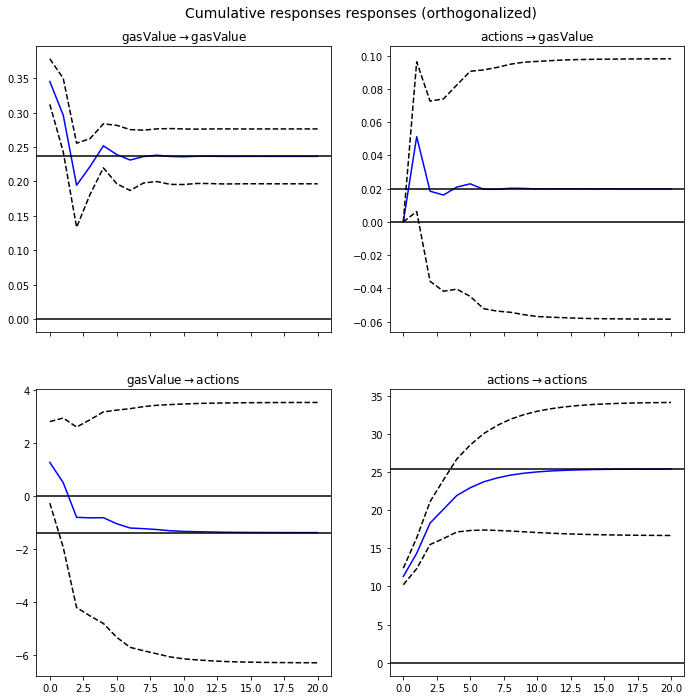

In [68]:
irf2.plot_cum_effects(orth=True)

In [69]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.978743  0.021257
2     0.972575  0.027425
3     0.972685  0.027315
4     0.972702  0.027298
5     0.972707  0.027293
6     0.972643  0.027357
7     0.972648  0.027352
8     0.972646  0.027354
9     0.972646  0.027354
10    0.972646  0.027354
11    0.972646  0.027354
12    0.972646  0.027354
13    0.972646  0.027354
14    0.972646  0.027354
15    0.972646  0.027354
16    0.972646  0.027354
17    0.972646  0.027354
18    0.972646  0.027354
19    0.972646  0.027354

FEVD for actions
      gasValue   actions
0     0.012281  0.987719
1     0.015628  0.984372
2     0.024800  0.975200
3     0.024292  0.975708
4     0.023806  0.976194
5     0.023967  0.976033
6     0.024034  0.975966
7     0.024001  0.975999
8     0.023987  0.976013
9     0.023990  0.976010
10    0.023990  0.976010
11    0.023988  0.976012
12    0.023988  0.976012
13    0.023988  0.976012
14    0.023988  0.976012
15    0.023988  0.976012
16    0.023988

In [70]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
2874.,9.488,0.000,4


In [71]:
results2.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
79.83,92.81,0.247,72


In [72]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
2.536,3.841,0.111,1


In [73]:
results2.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
3.047,3.018,0.049,"(2, 408)"
